# Computing physical statistics
_@Lutecity April 2023_

**Description**

This notebook computes physical statistics on players during the game such as: velocity, distance covered, distance covered while walking, jogging, running, sprinting,  number of sustained sprints, etc. These codes will be used in the application in order to provide insights on the physical performances of the players for the staff during the game.

This notebook also processes data provided by Second Spectrum to match the dataset format used in Laurie Shaw package. The dataset is exported and used in the app.

The inspiration and large pieces of code come from the work of Sudarshan Gopaladesikan [Github: Sportsdatascience](https://github.com/slbenfica1079/sportsdatascience) and Laurie Shaw [Tutorial on Friends of Tracking](https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking)

**Summary**

1. [Import the data](#data)
2. [Data pre processing](#data-processing)
3. [Physical stats](#stats)
    1. [Player velocities](#velocities)
    2. [Minutes played by each player](#minutes_played)
    3. [Distance covered by each player](#distance_covered)
    4. [Distance covered by each player while: walking, jogging, running, sprinting](#distance_covered_on_each_speed)
    5. [Sustained sprints](#sustained_sprints)
4. [Aggregate stats](#aggregate)
5. [Metabolic power](#metabolic_power)
    1. [Number of Accelerations and Decelerations](#nb_acc_dec)
    2. [Calculate metabolic cost and metabolic power](#metabolic_cost)

## Import the data <a id="data"></a>
#### Librairies

In [2]:
import pandas as pd 
import numpy as np
import os
import seaborn
from sklearn import linear_model
import matplotlib.pyplot as plt
import scipy as sp
import ruptures as rpt
import math

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('max_colwidth', 400)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

# Plotly
import plotly.graph_objs as go
from floodlight.io.secondspectrum import read_position_data_jsonl, read_teamsheets_from_meta_json

Laurie Shaw package:

In [3]:
import LaurieOnTracking_package.Metrica_IO as mio
import LaurieOnTracking_package.Metrica_Velocities as mvel
import LaurieOnTracking_package.Metrica_Viz as mviz

#### Data

In [4]:
filepath_insight = os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/Data/Second_Spectrum/g2312135_SecondSpectrum_tracking-produced.jsonl"
filepath_metadata = os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/Data/Second_Spectrum/g2312135_SecondSpectrum_meta.json"

In [5]:
teamsheet = read_teamsheets_from_meta_json(filepath_metadata)
teamsheet_home = teamsheet['Home']
teamsheet_away = teamsheet['Away']

In [6]:
dataset = read_position_data_jsonl(filepath_insight, 
                                    filepath_metadata,
                                    teamsheet_home = teamsheet_home ,
                                    teamsheet_away = teamsheet_away)

In [7]:
xy_objects = dataset[0]
possession_objects = dataset[1]
ballstatus_objects = dataset[2]
teamsheets = dataset[3]
pitch = dataset[4]

HT1_home = xy_objects['HT1']['Home']
HT1_away = xy_objects['HT1']['Away']
HT2_home = xy_objects['HT2']['Home']
HT2_away = xy_objects['HT2']['Away']
HT1_possession =possession_objects['HT1']
HT2_possession =possession_objects['HT2']
HT1_ballstatus =ballstatus_objects['HT1']
HT2_ballstatus =ballstatus_objects['HT2']
home_team = teamsheets['Home']
away_team = teamsheets['Away']

## Data pre processing <a id="data-processing"></a>

The goal is to create a dataframe to match the format use by Laurie Shaw on its package.

In [8]:
def create_dataframe_tracking_data(xy_objects,teamsheet, period, teamname):
    df = pd.DataFrame()
    df['Frame'] = [i for i in range(len(xy_objects))]
    df['Period'] = period
    df['Time [s]'] = df['Frame'] / 25

    xID = teamsheet['xID']
    columns = df.columns.to_list() + [0]*len(xy_objects[0])
    for i, j in enumerate(xID):
        columns[i*2+3] = "{}_{}_x".format(teamname, j)
        columns[i*2+4] = "{}_{}_y".format(teamname, j)
    df_xy = pd.DataFrame(xy_objects.xy)
    df_final = pd.concat([df,df_xy],axis=1)
    df_final.columns = columns
    df_final = df_final.astype(float)
    df_final['Direction'] = xy_objects.direction
    return(df_final)

In [9]:
HT1_home = create_dataframe_tracking_data(HT1_home,home_team, 1, 'Home')
HT2_home = create_dataframe_tracking_data(HT2_home,home_team, 2, 'Home')
HT1_away = create_dataframe_tracking_data(HT1_away,away_team, 1, 'Away')
HT2_away = create_dataframe_tracking_data(HT2_away,away_team, 2, 'Away')

In [10]:
HT1_home

,Frame,Period,Time [s],Home_0_x,Home_0_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,Home_4_x,Home_4_y,Home_5_x,Home_5_y,Home_6_x,Home_6_y,Home_7_x,Home_7_y,Home_8_x,Home_8_y,Home_9_x,Home_9_y,Home_10_x,Home_10_y,Home_11_x,Home_11_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,Home_15_x,Home_15_y,Home_16_x,Home_16_y,Direction
0,0.0,1.0,0.00,-46.26,0.16,-12.99,-23.00,-11.08,1.55,-1.20,-13.96,0.24,-0.45,-0.12,24.02,-22.61,7.47,-21.61,-8.56,-0.15,-30.50,-15.36,17.27,-2.71,8.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lr
1,1.0,1.0,0.04,-46.22,0.14,-13.00,-23.03,-11.08,1.57,-1.22,-13.95,0.24,-0.44,-0.12,24.01,-22.61,7.47,-21.60,-8.56,-0.16,-30.45,-15.36,17.27,-2.71,8.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lr
2,2.0,1.0,0.08,-46.18,0.13,-13.00,-23.05,-11.07,1.59,-1.24,-13.93,0.26,-0.43,-0.12,24.01,-22.61,7.46,-21.58,-8.56,-0.18,-30.41,-15.36,17.27,-2.71,8.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lr
3,3.0,1.0,0.12,-46.14,0.12,-13.01,-23.07,-11.07,1.61,-1.27,-13.92,0.27,-0.42,-0.12,24.00,-22.62,7.46,-21.57,-8.56,-0.20,-30.37,-15.36,17.27,-2.72,8.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lr
4,4.0,1.0,0.16,-46.10,0.10,-13.01,-23.09,-11.05,1.63,-1.29,-13.90,0.30,-0.41,-0.11,24.00,-22.62,7.45,-21.56,-8.56,-0.22,-30.34,-15.36,17.27,-2.72,8.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76662,76662.0,1.0,3066.48,-31.66,-3.16,27.03,-33.57,25.22,-25.87,30.21,-29.32,41.52,-25.49,33.44,10.61,6.77,-14.07,11.64,-30.93,40.35,-32.43,19.56,-8.13,33.32,-2.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lr
76663,76663.0,1.0,3066.52,-31.69,-3.14,27.02,-33.57,25.15,-25.89,30.16,-29.33,41.50,-25.49,33.40,10.59,6.74,-14.12,11.58,-30.93,40.32,-32.44,19.52,-8.17,33.27,-2.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lr
76664,76664.0,1.0,3066.56,-31.72,-3.12,27.02,-33.57,25.08,-25.90,30.10,-29.34,41.49,-25.49,33.36,10.58,6.73,-14.18,11.51,-30.94,40.30,-32.44,19.47,-8.21,33.22,-2.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lr
76665,76665.0,1.0,3066.60,-31.75,-3.09,27.01,-33.57,25.01,-25.92,30.06,-29.35,41.48,-25.49,33.33,10.57,6.70,-14.24,11.45,-30.95,40.28,-32.45,19.42,-8.25,33.17,-2.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lr


Concatenate the first and second half.

In [11]:
tracking_home = pd.concat([HT1_home,HT2_home]).reset_index(drop=True)
tracking_home['Frame'] = tracking_home.index
tracking_home['Time [s]'] = tracking_home['Frame'] / 25

tracking_away = pd.concat([HT1_away,HT2_away]).reset_index(drop=True)
tracking_away['Frame'] = tracking_away.index
tracking_away['Time [s]'] = tracking_away['Frame'] / 25

Reverse direction of play in the second half so that home team is always attacking from left to right

In [12]:
def to_single_playing_direction(home,away):
    '''
    Flip coordinates in second half so that each team always shoots in the same direction through the match.
    '''
    for team in [home,away]:
        direction_first_half = team[team['Period']==1]['Direction'].unique()[0]
        second_half_idx = team[team['Period']==2].index.to_list()
        columns = [c for c in team.columns if c[-1].lower() in ['x','y']]
        team.loc[second_half_idx,columns] *= -1
        team.loc[second_half_idx,'Direction'] = direction_first_half
    return home,away

tracking_home, tracking_away = to_single_playing_direction(tracking_home, tracking_away)

Find goalkeeper number and home attack direction

In [13]:
def find_goalkeeper(team):
    '''
    Find the goalkeeper in team, identifying him/her as the player closest to goal at kick off
    ''' 
    x_columns = [c for c in team.columns if c[-2:].lower()=='_x' and c[:4] in ['Home','Away']]
    GK_col = team.iloc[0][x_columns].abs().astype(float).idxmax()
    return GK_col.split('_')[1]
    
GK_numbers = [find_goalkeeper(tracking_home),find_goalkeeper(tracking_away)]
home_attack_direction = tracking_home['Direction'].replace({'lr': -1, 'rl':1}).unique()[0]


In [15]:
# tracking_home.to_csv('Output/tracking_home.csv',encoding='utf-8-sig',sep = ";", index=False, header=True)
# tracking_away.to_csv('Output/tracking_away.csv',encoding='utf-8-sig',sep = ";", index=False, header=True)

## Physical stats <a id="stats"></a>

### Player velocities <a id="velocities"></a>

In [16]:
# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)

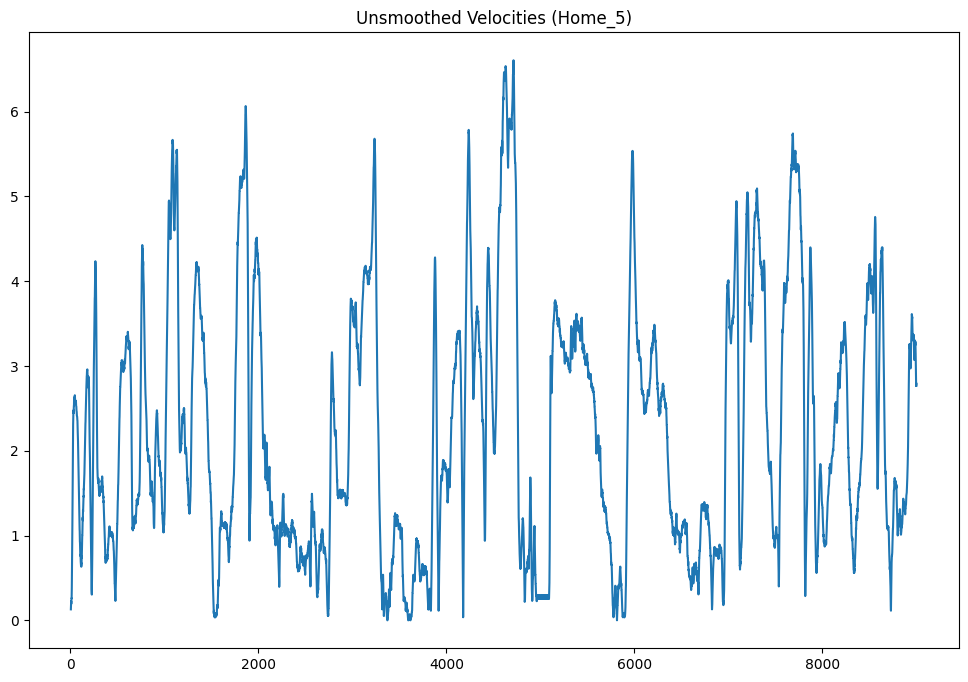

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(range(1, 9001), tracking_home.loc[1:9000]['Home_5_speed'])
ax.title.set_text('Unsmoothed Velocities (Home_5)')

### Minutes played by each player <a id="minutes_played"></a>

In [18]:
def calculate_minutes_played(df_tracking, teamname):
    player_columns = [c.split('_')[1] for c in df_tracking.columns if c[-2:].lower()=='_x' and c[:4] in ['Home','Away']]
    minutes = []
    for player in player_columns:
        # search for first and last frames that we have a position observation for each player (when a player is not on the pitch positions are NaN)
        column = teamname + '_' + player + '_x' # use player x-position coordinate
        last_index = df_tracking[column].last_valid_index()
        first_index = df_tracking[column].first_valid_index()
        if first_index is not None and last_index is not None: 
            player_minutes = ( last_index - first_index + 1 ) / 25 / 60. # convert to minutes
        else : 
            player_minutes = 0
        minutes.append( player_minutes )
    return(minutes)


### Distance covered by each player <a id="distance_covered"></a>

In [19]:
def calculate_total_distance_covered(df_tracking, teamname) : 
    player_columns = [c.split('_')[1] for c in df_tracking.columns if c[-2:].lower()=='_x' and c[:4] in ['Home','Away']]
    distance = []
    for player in player_columns:
        column = teamname +'_' + player + '_speed'
        player_distance = df_tracking[column].sum()/25./1000 # this is the sum of the distance travelled from one observation to the next (1/25 = 40ms) in km.
        distance.append( player_distance )
    return(distance)

### Distance covered by each player while: walking, jogging, running, sprinting <a id="distance_covered_on_each_speed"></a>

Walking is defined as a speed of less than 2 m/s.

Jogging is defined by a speed between 2 and 4 m/s.

Running is defined by a speed between 4 and 7 m/s.

Sprinting  is defined as a speed greater than 7 m/s.

In [20]:
def calculate_distance_in_each_speed(df_tracking, teamname) : 
    walking = []
    jogging = []
    running = []
    sprinting = []
    player_columns = [c.split('_')[1] for c in df_tracking.columns if c[-2:].lower()=='_x' and c[:4] in ['Home','Away']]
    for player in player_columns:
        column = teamname + '_' + player + '_speed'
        # walking (less than 2 m/s)
        player_distance = df_tracking.loc[df_tracking[column] < 2, column].sum()/25./1000
        walking.append( player_distance )
        # jogging (between 2 and 4 m/s)
        player_distance = df_tracking.loc[ (df_tracking[column] >= 2) & (df_tracking[column] < 4), column].sum()/25./1000
        jogging.append( player_distance )
        # running (between 4 and 7 m/s)
        player_distance = df_tracking.loc[ (df_tracking[column] >= 4) & (df_tracking[column] < 7), column].sum()/25./1000
        running.append( player_distance )
        # sprinting (greater than 7 m/s)
        player_distance = df_tracking.loc[ df_tracking[column] >= 7, column].sum()/25./1000
        sprinting.append( player_distance )
    
    return walking, jogging, running, sprinting

### Sustained sprints<a id="sustained_sprints"></a>

How many sustained sprints per match did each player complete? Defined as maintaining a speed > 7 m/s for at least 1 second

In [21]:
# sustained sprints: 
def calculate_nb_sustained_sprints(df_tracking, teamname) : 
    nsprints = []
    sprint_threshold = 7 # minimum speed to be defined as a sprint (m/s)
    sprint_window = 1*25 # minimum duration sprint should be sustained (in this case, 1 second = 25 consecutive frames)
    player_columns = [c.split('_')[1] for c in df_tracking.columns if c[-2:].lower()=='_x' and c[:4] in ['Home','Away']]
    for player in player_columns:
        column = teamname+ '_' + player + '_speed'
        # trick here is to convolve speed with a window of size 'sprint_window', and find number of occassions that sprint was sustained for at least one window length
        # diff helps us to identify when the window starts
        player_sprints = np.diff( 1*( np.convolve( 1*(df_tracking[column]>=sprint_threshold), np.ones(sprint_window), mode='same' ) >= sprint_window ) )
        nsprints.append( np.sum( player_sprints == 1 ) )

    return(nsprints)

## Aggregate statistics

In [22]:
def aggregate_statistics(df_tracking, teamsheet_home, teamname) : 
    df_summary = teamsheet_home[['jID','player']]
    
    minutes = calculate_minutes_played(df_tracking,teamname)
    df_summary.loc[:,'Minutes Played'] = minutes

    distance = calculate_total_distance_covered(df_tracking,teamname)
    df_summary.loc[:,'Distance [km]'] = distance

    walking, jogging, running, sprinting = calculate_distance_in_each_speed(df_tracking,teamname)
    df_summary.loc[:,'Walking [km]'] = walking
    df_summary.loc[:,'Jogging [km]'] = jogging
    df_summary.loc[:,'Running [km]'] = running
    df_summary.loc[:,'Sprinting [km]'] = sprinting

    nsprints = calculate_nb_sustained_sprints(df_tracking, teamname)
    df_summary['Number of sprints'] = nsprints
    
    return(df_summary)

In [23]:
df_summary = aggregate_statistics(tracking_home,teamsheet_home, teamname = 'Home')
df_summary

,jID,player,Minutes Played,Distance [km],Walking [km],Jogging [km],Running [km],Sprinting [km],Number of sprints
0,1,E. Roebuck,101.070000,4.749804,3.422714,1.226594,0.100497,0.000000,0
1,2,K. Casparij,101.070000,10.422734,3.530425,4.751290,2.032365,0.108654,8
2,25,Y. Hasegawa,101.070000,11.193728,3.138884,5.430833,2.618157,0.005854,0
3,12,Filippa Angeldahl,101.070000,11.875375,3.240192,5.520611,3.039320,0.075253,4
4,21,Khadija Shaw,101.070000,10.639256,4.091697,3.961544,2.477936,0.108079,6
5,11,L. Hemp,101.070000,10.024216,4.052792,3.362572,2.419377,0.189474,9
6,5,A. Greenwood,101.070000,9.714811,3.662369,4.120957,1.908605,0.022879,1
7,6,S. Houghton,101.070000,9.890223,4.145386,3.895864,1.785498,0.063476,4
8,9,C. Kelly,96.628667,9.719534,4.006203,3.840098,1.803498,0.069734,4
9,4,L. Aleixandri,101.070000,10.372192,3.555666,4.700634,2.107918,0.007974,0


In [24]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x = df_summary['player'],
        y = df_summary['Distance [km]']
    )
)
fig.update_layout(
    xaxis = {
        'title' : 'Player'
    },
    yaxis = {
        'title' : 'Distance covered [km]'
    },
    template="plotly_white"
)
fig.show()

In [25]:
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x = df_summary['player'],
        y = df_summary['Walking [km]'],
        name = 'Walking [km]'
    )
)

fig.add_trace(
    go.Bar(
        x = df_summary['player'],
        y = df_summary['Jogging [km]'],
        name = 'Jogging [km]'
    )
)

fig.add_trace(
    go.Bar(
        x = df_summary['player'],
        y = df_summary['Running [km]'],
        name = 'Running [km]'
    )
)

fig.add_trace(
    go.Bar(
        x = df_summary['player'],
        y = df_summary['Sprinting [km]'],
        name = 'Sprinting [km]'
    )
)

fig.update_layout(barmode='group')
fig.update_layout(
    xaxis = {
        'title' : 'Player'
    },
    yaxis = {
        'title' : 'Distance covered [km]'
    },
    template="plotly_white"
)
fig.show()